In [2]:
# Import necessary libraries
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from datetime import datetime, timedelta

In [3]:
# Add project directory to path
import os
import sys
sys.path.append(os.path.abspath(".."))

# Import custom modules
from src.data.data_ingestion import DataIngestion,DataIngestionConfig
from src.data.data_preprocessing import DataPreprocessing
from src.strategies.pairs_trading import PairsTrading
from src.strategies.mean_reversion import MeanReversion
from src.utils.logger import get_logger


In [4]:
# Initialize logger
logger = get_logger("trading_signals_notebook")
logger.info("Starting trading signals generation")

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 8)

# 1. Load processed data
logger.info("Loading processed data")


[ 2025-05-11 20:04:23,878 ] 3 trading_signals_notebook - INFO - Starting trading signals generation
[ 2025-05-11 20:04:23,879 ] 10 trading_signals_notebook - INFO - Loading processed data


In [5]:
custom_config = DataIngestionConfig()
# Fix the path - go up one level from notebooks directory
custom_config.project_root = os.path.dirname(os.getcwd())  
custom_config.raw_data_path = os.path.join(custom_config.project_root, 'data', 'raw', 'Portfolio_prices.csv')
custom_config.processed_data_dir = os.path.join(custom_config.project_root, 'data', 'processed')
data_preprocessor = DataPreprocessing()

# Use the existing DataIngestion class with our fixed config
data_ingestion = DataIngestion(config=custom_config)
raw_df = data_ingestion.read_data()

print(f"Dataset shape: {raw_df.shape}")
raw_df.head()

[ 2025-05-11 20:04:39,742 ] 47 src.data.data_ingestion - INFO - Raw data path: d:\projects\Relative-Value-Analysis-Pairs-Trading\data\raw\Portfolio_prices.csv
[ 2025-05-11 20:04:39,744 ] 48 src.data.data_ingestion - INFO - File exists: True
[ 2025-05-11 20:04:39,745 ] 61 src.data.data_ingestion - INFO - Started reading data from d:\projects\Relative-Value-Analysis-Pairs-Trading\data\raw\Portfolio_prices.csv
[ 2025-05-11 20:04:39,811 ] 76 src.data.data_ingestion - INFO - Successfully read data with shape: (35397, 9)


Dataset shape: (35397, 9)


,Date,Ticker,Open,High,Low,Close,Adjusted,Returns,Volume
0,2020-01-03,JPM,137.500000,139.229996,137.080002,138.339996,119.874138,-0.013197,10386800
1,2020-01-03,KO,54.320000,54.990002,54.090000,54.689999,46.494698,-0.005455,11354500
2,2020-01-03,LMT,404.019989,417.170013,403.000000,413.739990,359.312317,0.035981,2990100
3,2020-01-03,MS,51.220001,51.450001,50.830002,51.200001,43.273079,-0.016142,6706000
4,2020-01-03,MSCI,262.200012,263.579987,259.269989,260.750000,248.019470,-0.019921,459700


In [16]:
processed_df = data_preprocessor.preprocess_data(raw_df)


[ 2025-05-11 20:06:03,135 ] 185 src.data.data_preprocessing - INFO - Starting data preprocessing
[ 2025-05-11 20:06:03,137 ] 82 src.data.data_preprocessing - INFO - Converting Date to datetime format
[ 2025-05-11 20:06:03,148 ] 87 src.data.data_preprocessing - INFO - Successfully converted Date to datetime format
[ 2025-05-11 20:06:03,149 ] 108 src.data.data_preprocessing - INFO - Handling missing values
[ 2025-05-11 20:06:03,155 ] 112 src.data.data_preprocessing - INFO - Missing values before handling: Date        0
Ticker      0
Open        0
High        0
Low         0
Close       0
Adjusted    0
Returns     0
Volume      0
dtype: int64
d:\projects\Relative-Value-Analysis-Pairs-Trading\src\data\data_preprocessing.py:116: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[numeric_cols] = df[numeric_cols].fillna(method='ffill')
[ 2025-05-11 20:06:03,167 ] 120 src.data.data_preprocessing - INFO - 

In [6]:
# 2. Load the cointegrated pairs from previous step
logger.info("Loading cointegrated pairs")


[ 2025-05-11 20:04:49,418 ] 2 trading_signals_notebook - INFO - Loading cointegrated pairs


In [7]:
# Path to cointegrated pairs
cointegrated_pairs_path = os.path.join('..', 'data', 'processed', 'cointegrated_pairs.csv')


In [8]:
# Check if file exists
if os.path.exists(cointegrated_pairs_path):
    cointegrated_pairs_df = pd.read_csv(cointegrated_pairs_path)
    logger.info(f"Loaded {len(cointegrated_pairs_df)} cointegrated pairs")
    display(cointegrated_pairs_df.head())
else:
    logger.error("Cointegrated pairs file not found. Cannot proceed with signal generation.")
    raise FileNotFoundError("Cointegrated pairs file not found. Run the cointegration tests notebook first.")


[ 2025-05-11 20:05:01,225 ] 4 trading_signals_notebook - INFO - Loaded 11 cointegrated pairs


,Ticker1,Ticker2,IsCointegrated,TestMethod,PValue,TStatistic
0,AAPL,PG,True,engle_granger,0.000302,-4.854859
1,IBKR,TMUS,True,engle_granger,0.006286,-4.040289
2,PG,SPY,True,engle_granger,0.030969,-3.516399
3,CAT,MSFT,True,engle_granger,0.049473,-3.339936
4,MSFT,PG,True,engle_granger,0.044722,-3.379134


In [9]:
# 3. Set up signal generation parameters
logger.info("Setting up signal generation parameters")


[ 2025-05-11 20:05:05,597 ] 2 trading_signals_notebook - INFO - Setting up signal generation parameters


In [10]:
# Parameters for signal generation
lookback_period = 60  # Days to look back for calculating z-score
entry_threshold = 2.0  # Z-score threshold to enter a position
exit_threshold = 0.5   # Z-score threshold to exit a position
stop_loss = 4.0        # Maximum z-score deviation before triggering a stop loss
max_holding_period = 20  # Maximum number of days to hold a position


In [11]:
# Initialize strategies
pairs_strategy = PairsTrading(
    lookback_period=lookback_period,
    entry_threshold=entry_threshold,
    exit_threshold=exit_threshold,
    stop_loss=stop_loss,
    max_holding_period=max_holding_period
)



[ 2025-05-11 20:05:14,399 ] 44 PairsTrading - INFO - Initialized PairsTrading strategy with parameters: lookback_period=60, entry_threshold=2.0, exit_threshold=0.5, stop_loss=4.0, max_holding_period=20, position_size=1.0


In [12]:
mean_reversion = MeanReversion()


[ 2025-05-11 20:05:18,322 ] 23 MeanReversion - INFO - Initialized MeanReversion class


In [13]:
# 4. Generate signals for each cointegrated pair
logger.info("Generating trading signals")


[ 2025-05-11 20:05:21,804 ] 2 trading_signals_notebook - INFO - Generating trading signals


In [14]:
# Store results for all pairs
all_pair_results = {}


In [21]:
# Process each cointegrated pair
for idx, row in cointegrated_pairs_df.iterrows():
    ticker1 = row['Ticker1']
    ticker2 = row['Ticker2']
    pair_name = f"{ticker1}-{ticker2}"
    
    logger.info(f"Processing pair {pair_name} ({idx+1}/{len(cointegrated_pairs_df)})")
    
    # Filter data for the two tickers
    pair_data = processed_df[processed_df['Ticker'].isin([ticker1, ticker2])]
    
    # Pivot to get time series
    pivot_df = pair_data.pivot(index='Date', columns='Ticker', values='Adjusted')
    
    # Get price series
    price1 = pivot_df[ticker1]
    price2 = pivot_df[ticker2]
    
    # Calculate hedge ratio using linear regression
    X = sm.add_constant(price2)
    model = sm.OLS(price1, X).fit()
    hedge_ratio = model.params[1]
    
    # Calculate spread
    spread = price1 - hedge_ratio * price2
    
    # Calculate z-score
    zscore = pairs_strategy.calculate_zscore(spread)
    
    # Generate signals
    signals = pairs_strategy.generate_signals(zscore)
    
    # Calculate returns
    returns = np.zeros_like(signals)
    for i in range(1, len(signals)):
        if signals[i-1] != 0:  # If we had a position in the previous period
            # Calculate return from the spread change
            spread_return = (spread.iloc[i] - spread.iloc[i-1]) / abs(spread.iloc[i-1])
            
            # Return depends on position direction
            returns[i] = signals[i-1] * spread_return
    
    # Calculate cumulative returns
    cum_returns = np.cumprod(1 + returns) - 1
    
    # Create a DataFrame with results
    result_df = pd.DataFrame({
        'Date': pivot_df.index,
        'Price1': price1.values,
        'Price2': price2.values,
        'Spread': spread.values,
        'Z-Score': zscore,
        'Signal': signals,
        'Return': returns,
        'CumulativeReturn': cum_returns
    })
    
    # Store the results
    all_pair_results[pair_name] = result_df
    
    # Print summary
    total_signals = np.sum(np.diff(signals) != 0)
    total_return = result_df['CumulativeReturn'].iloc[-1] if len(result_df) > 0 else 0
    print(f"Pair {pair_name}: Generated {total_signals} signals, Total Return: {total_return:.2%}")


[ 2025-05-11 20:10:01,409 ] 7 trading_signals_notebook - INFO - Processing pair AAPL-PG (1/11)
C:\Users\aumpa\AppData\Local\Temp\ipykernel_25444\3200359365.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[1]
d:\projects\Relative-Value-Analysis-Pairs-Trading\src\strategies\pairs_trading.py:117: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  zscore[i] = (spread[i] - mean) / std
[ 2025-05-11 20:10:01,722 ] 191 PairsTrading - INFO - Generated signals with 106 active positions
[ 2025-05-11 20:10:01,726 ] 7 trading_signals_notebook - INFO - Processing pair IBKR-TMUS (2/11)
C:\Users\aumpa\AppDa

Pair AAPL-PG: Generated 212 signals, Total Return: 44.30%


[ 2025-05-11 20:10:02,056 ] 191 PairsTrading - INFO - Generated signals with 134 active positions
[ 2025-05-11 20:10:02,062 ] 7 trading_signals_notebook - INFO - Processing pair PG-SPY (3/11)
C:\Users\aumpa\AppData\Local\Temp\ipykernel_25444\3200359365.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[1]
d:\projects\Relative-Value-Analysis-Pairs-Trading\src\strategies\pairs_trading.py:117: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  zscore[i] = (spread[i] - mean) / std


Pair IBKR-TMUS: Generated 268 signals, Total Return: 105.09%


[ 2025-05-11 20:10:02,344 ] 191 PairsTrading - INFO - Generated signals with 99 active positions
[ 2025-05-11 20:10:02,349 ] 7 trading_signals_notebook - INFO - Processing pair CAT-MSFT (4/11)
C:\Users\aumpa\AppData\Local\Temp\ipykernel_25444\3200359365.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[1]
d:\projects\Relative-Value-Analysis-Pairs-Trading\src\strategies\pairs_trading.py:117: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  zscore[i] = (spread[i] - mean) / std


Pair PG-SPY: Generated 198 signals, Total Return: 42.52%


[ 2025-05-11 20:10:02,646 ] 191 PairsTrading - INFO - Generated signals with 122 active positions
[ 2025-05-11 20:10:02,651 ] 7 trading_signals_notebook - INFO - Processing pair MSFT-PG (5/11)
C:\Users\aumpa\AppData\Local\Temp\ipykernel_25444\3200359365.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[1]
d:\projects\Relative-Value-Analysis-Pairs-Trading\src\strategies\pairs_trading.py:117: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  zscore[i] = (spread[i] - mean) / std


Pair CAT-MSFT: Generated 244 signals, Total Return: 13.25%


[ 2025-05-11 20:10:02,936 ] 191 PairsTrading - INFO - Generated signals with 104 active positions
[ 2025-05-11 20:10:02,941 ] 7 trading_signals_notebook - INFO - Processing pair CALM-TMUS (6/11)
C:\Users\aumpa\AppData\Local\Temp\ipykernel_25444\3200359365.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[1]
d:\projects\Relative-Value-Analysis-Pairs-Trading\src\strategies\pairs_trading.py:117: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  zscore[i] = (spread[i] - mean) / std


Pair MSFT-PG: Generated 208 signals, Total Return: 25.57%


[ 2025-05-11 20:10:03,216 ] 191 PairsTrading - INFO - Generated signals with 109 active positions
[ 2025-05-11 20:10:03,221 ] 7 trading_signals_notebook - INFO - Processing pair CAT-PG (7/11)
C:\Users\aumpa\AppData\Local\Temp\ipykernel_25444\3200359365.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[1]
d:\projects\Relative-Value-Analysis-Pairs-Trading\src\strategies\pairs_trading.py:117: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  zscore[i] = (spread[i] - mean) / std


Pair CALM-TMUS: Generated 218 signals, Total Return: -99.94%


[ 2025-05-11 20:10:03,509 ] 191 PairsTrading - INFO - Generated signals with 116 active positions
[ 2025-05-11 20:10:03,514 ] 7 trading_signals_notebook - INFO - Processing pair AAPL-CAT (8/11)
C:\Users\aumpa\AppData\Local\Temp\ipykernel_25444\3200359365.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[1]
d:\projects\Relative-Value-Analysis-Pairs-Trading\src\strategies\pairs_trading.py:117: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  zscore[i] = (spread[i] - mean) / std


Pair CAT-PG: Generated 232 signals, Total Return: -0.02%


[ 2025-05-11 20:10:03,788 ] 191 PairsTrading - INFO - Generated signals with 124 active positions
[ 2025-05-11 20:10:03,794 ] 7 trading_signals_notebook - INFO - Processing pair AAPL-KO (9/11)
C:\Users\aumpa\AppData\Local\Temp\ipykernel_25444\3200359365.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[1]
d:\projects\Relative-Value-Analysis-Pairs-Trading\src\strategies\pairs_trading.py:117: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  zscore[i] = (spread[i] - mean) / std


Pair AAPL-CAT: Generated 248 signals, Total Return: 387.47%


[ 2025-05-11 20:10:04,123 ] 191 PairsTrading - INFO - Generated signals with 123 active positions
[ 2025-05-11 20:10:04,131 ] 7 trading_signals_notebook - INFO - Processing pair CSCO-MS (10/11)
C:\Users\aumpa\AppData\Local\Temp\ipykernel_25444\3200359365.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[1]
d:\projects\Relative-Value-Analysis-Pairs-Trading\src\strategies\pairs_trading.py:117: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  zscore[i] = (spread[i] - mean) / std


Pair AAPL-KO: Generated 246 signals, Total Return: 35.13%


[ 2025-05-11 20:10:04,439 ] 191 PairsTrading - INFO - Generated signals with 118 active positions
[ 2025-05-11 20:10:04,444 ] 7 trading_signals_notebook - INFO - Processing pair CSCO-MSCI (11/11)
C:\Users\aumpa\AppData\Local\Temp\ipykernel_25444\3200359365.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[1]
d:\projects\Relative-Value-Analysis-Pairs-Trading\src\strategies\pairs_trading.py:117: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  zscore[i] = (spread[i] - mean) / std


Pair CSCO-MS: Generated 198 signals, Total Return: 28.26%


[ 2025-05-11 20:10:04,718 ] 191 PairsTrading - INFO - Generated signals with 101 active positions


Pair CSCO-MSCI: Generated 202 signals, Total Return: 29.21%


In [22]:
# 5. Visualize trading signals for selected pairs
logger.info("Visualizing trading signals")


[ 2025-05-11 20:10:08,958 ] 2 trading_signals_notebook - INFO - Visualizing trading signals


In [23]:
# Take top 3 pairs (or fewer if less than 3)
top_n = min(3, len(all_pair_results))
selected_pairs = list(all_pair_results.keys())[:top_n]


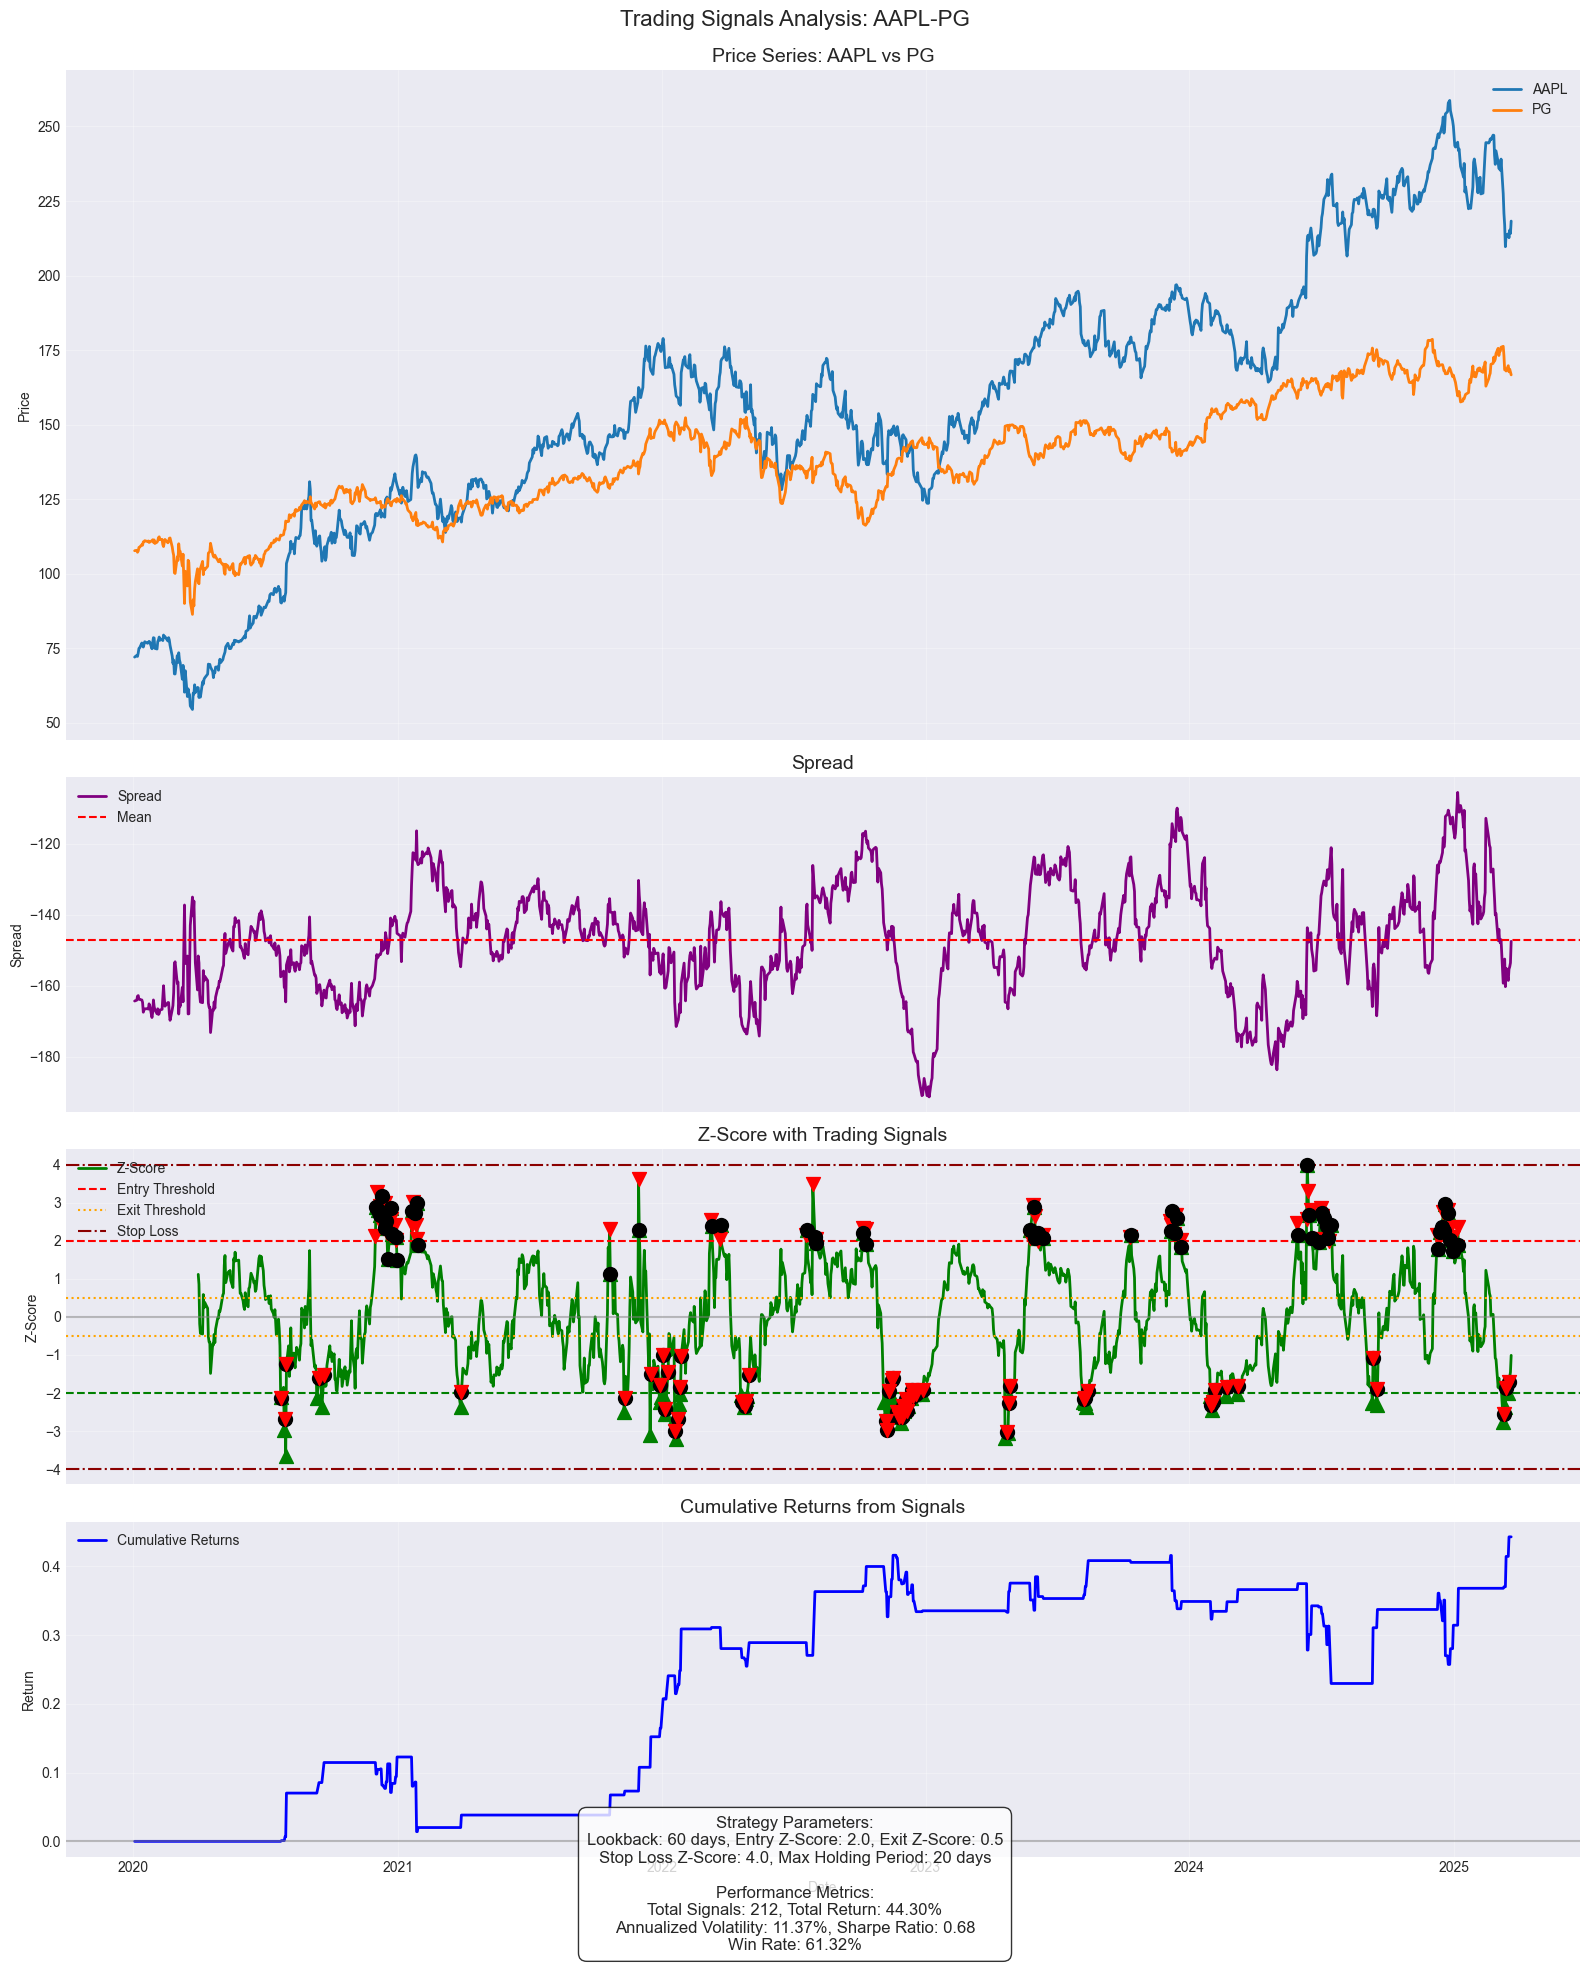

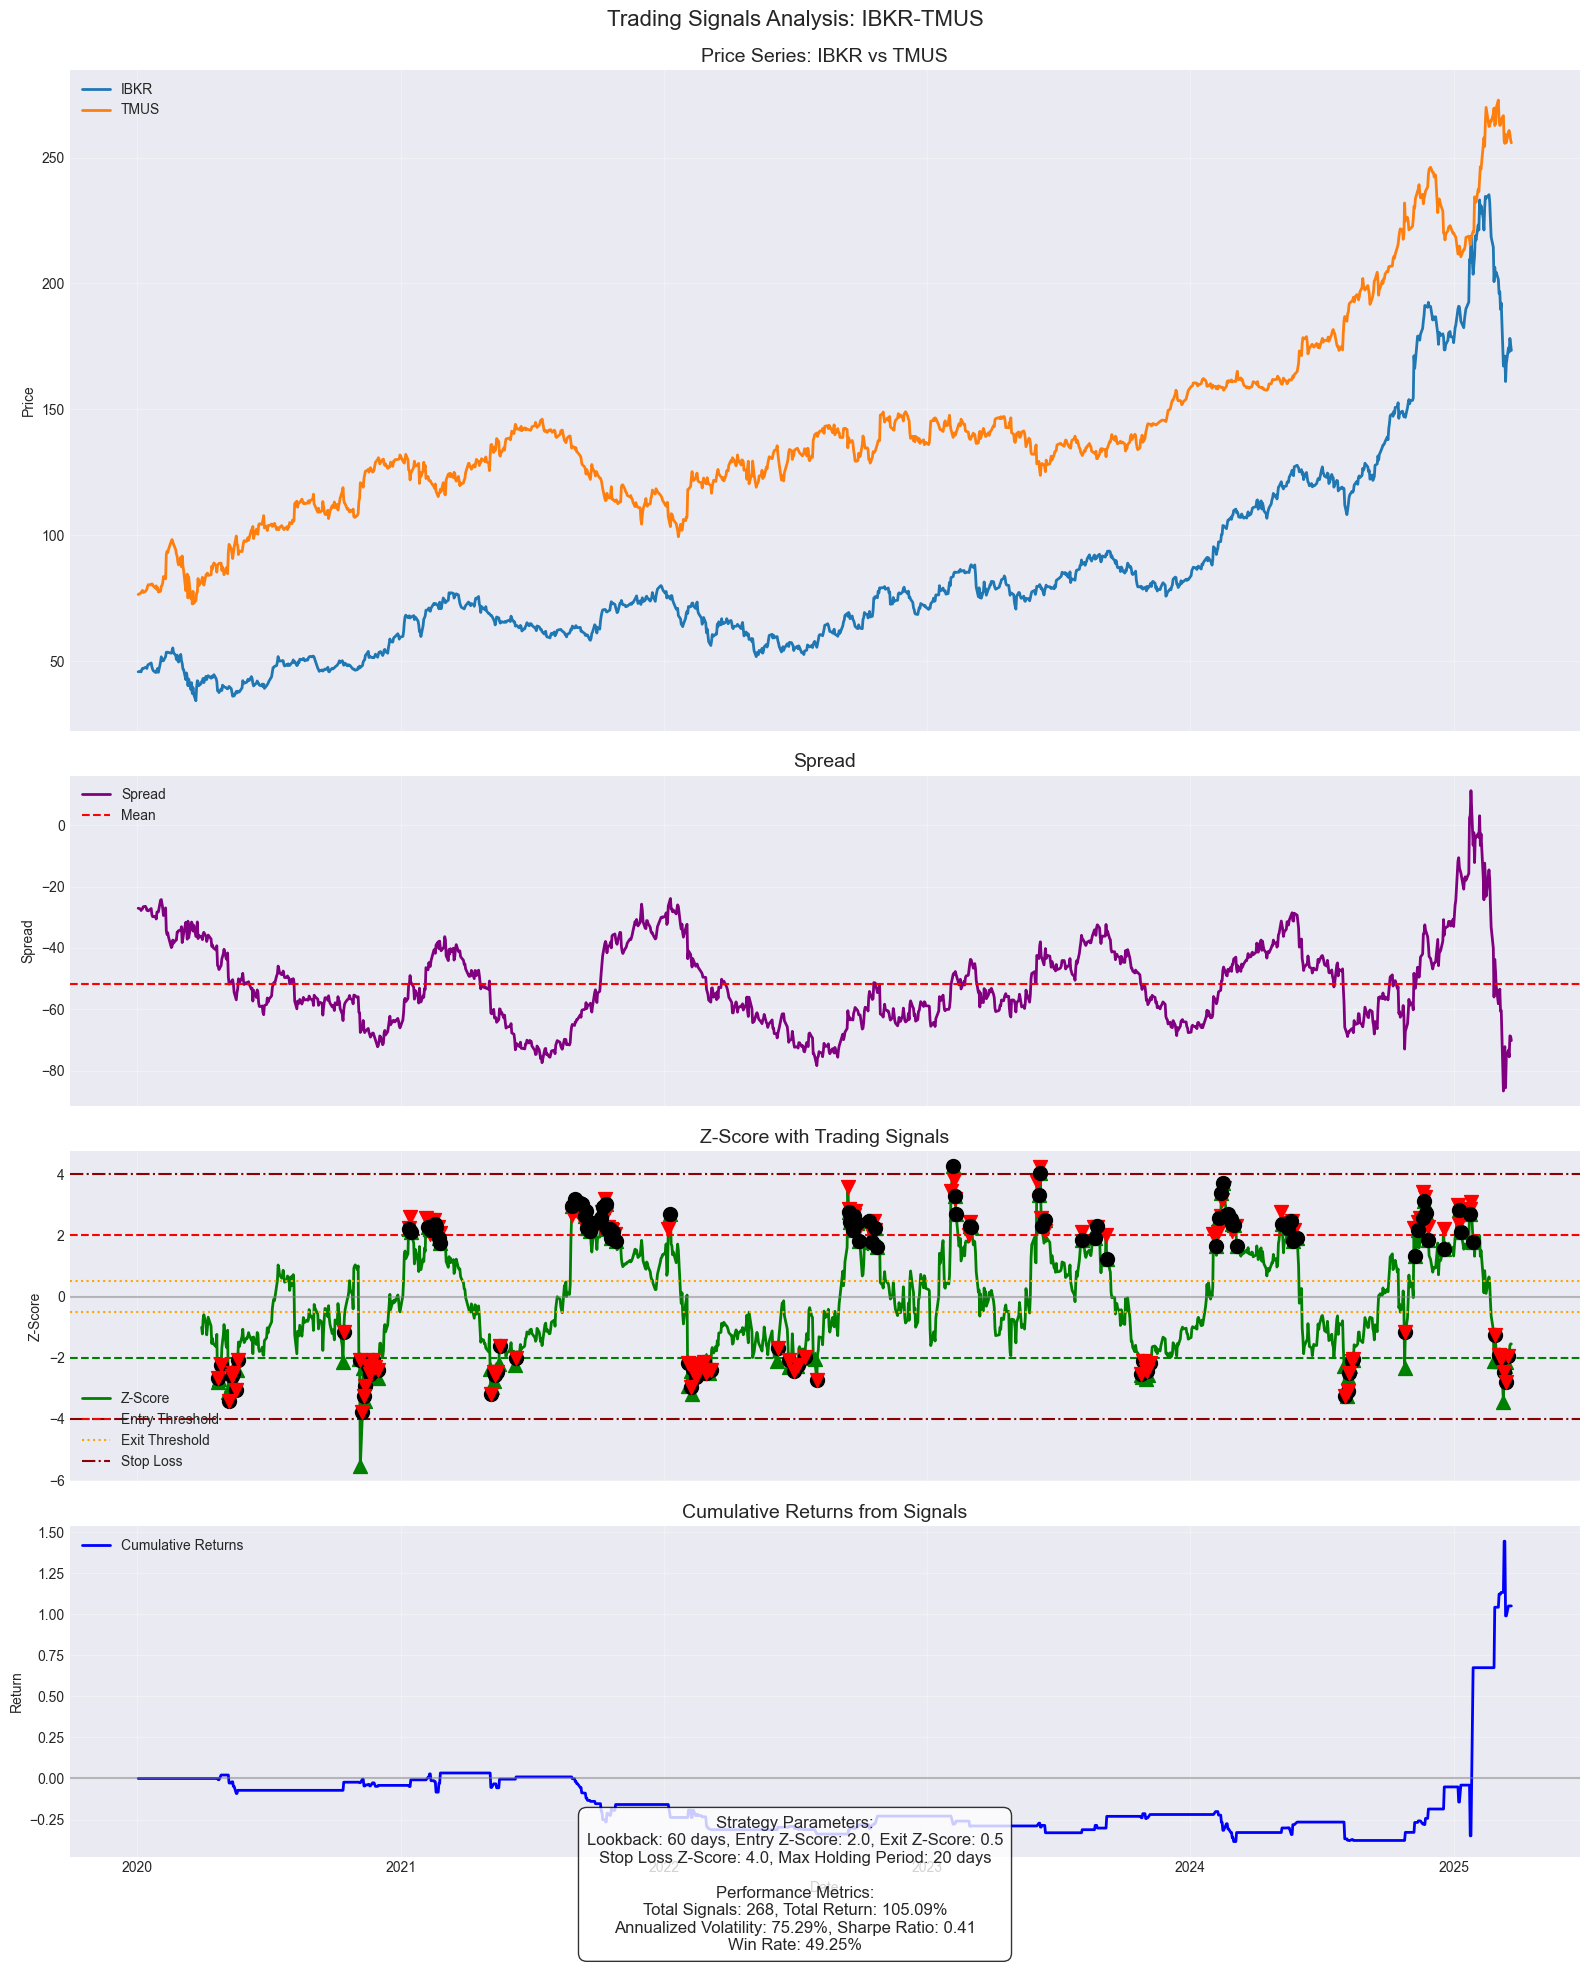

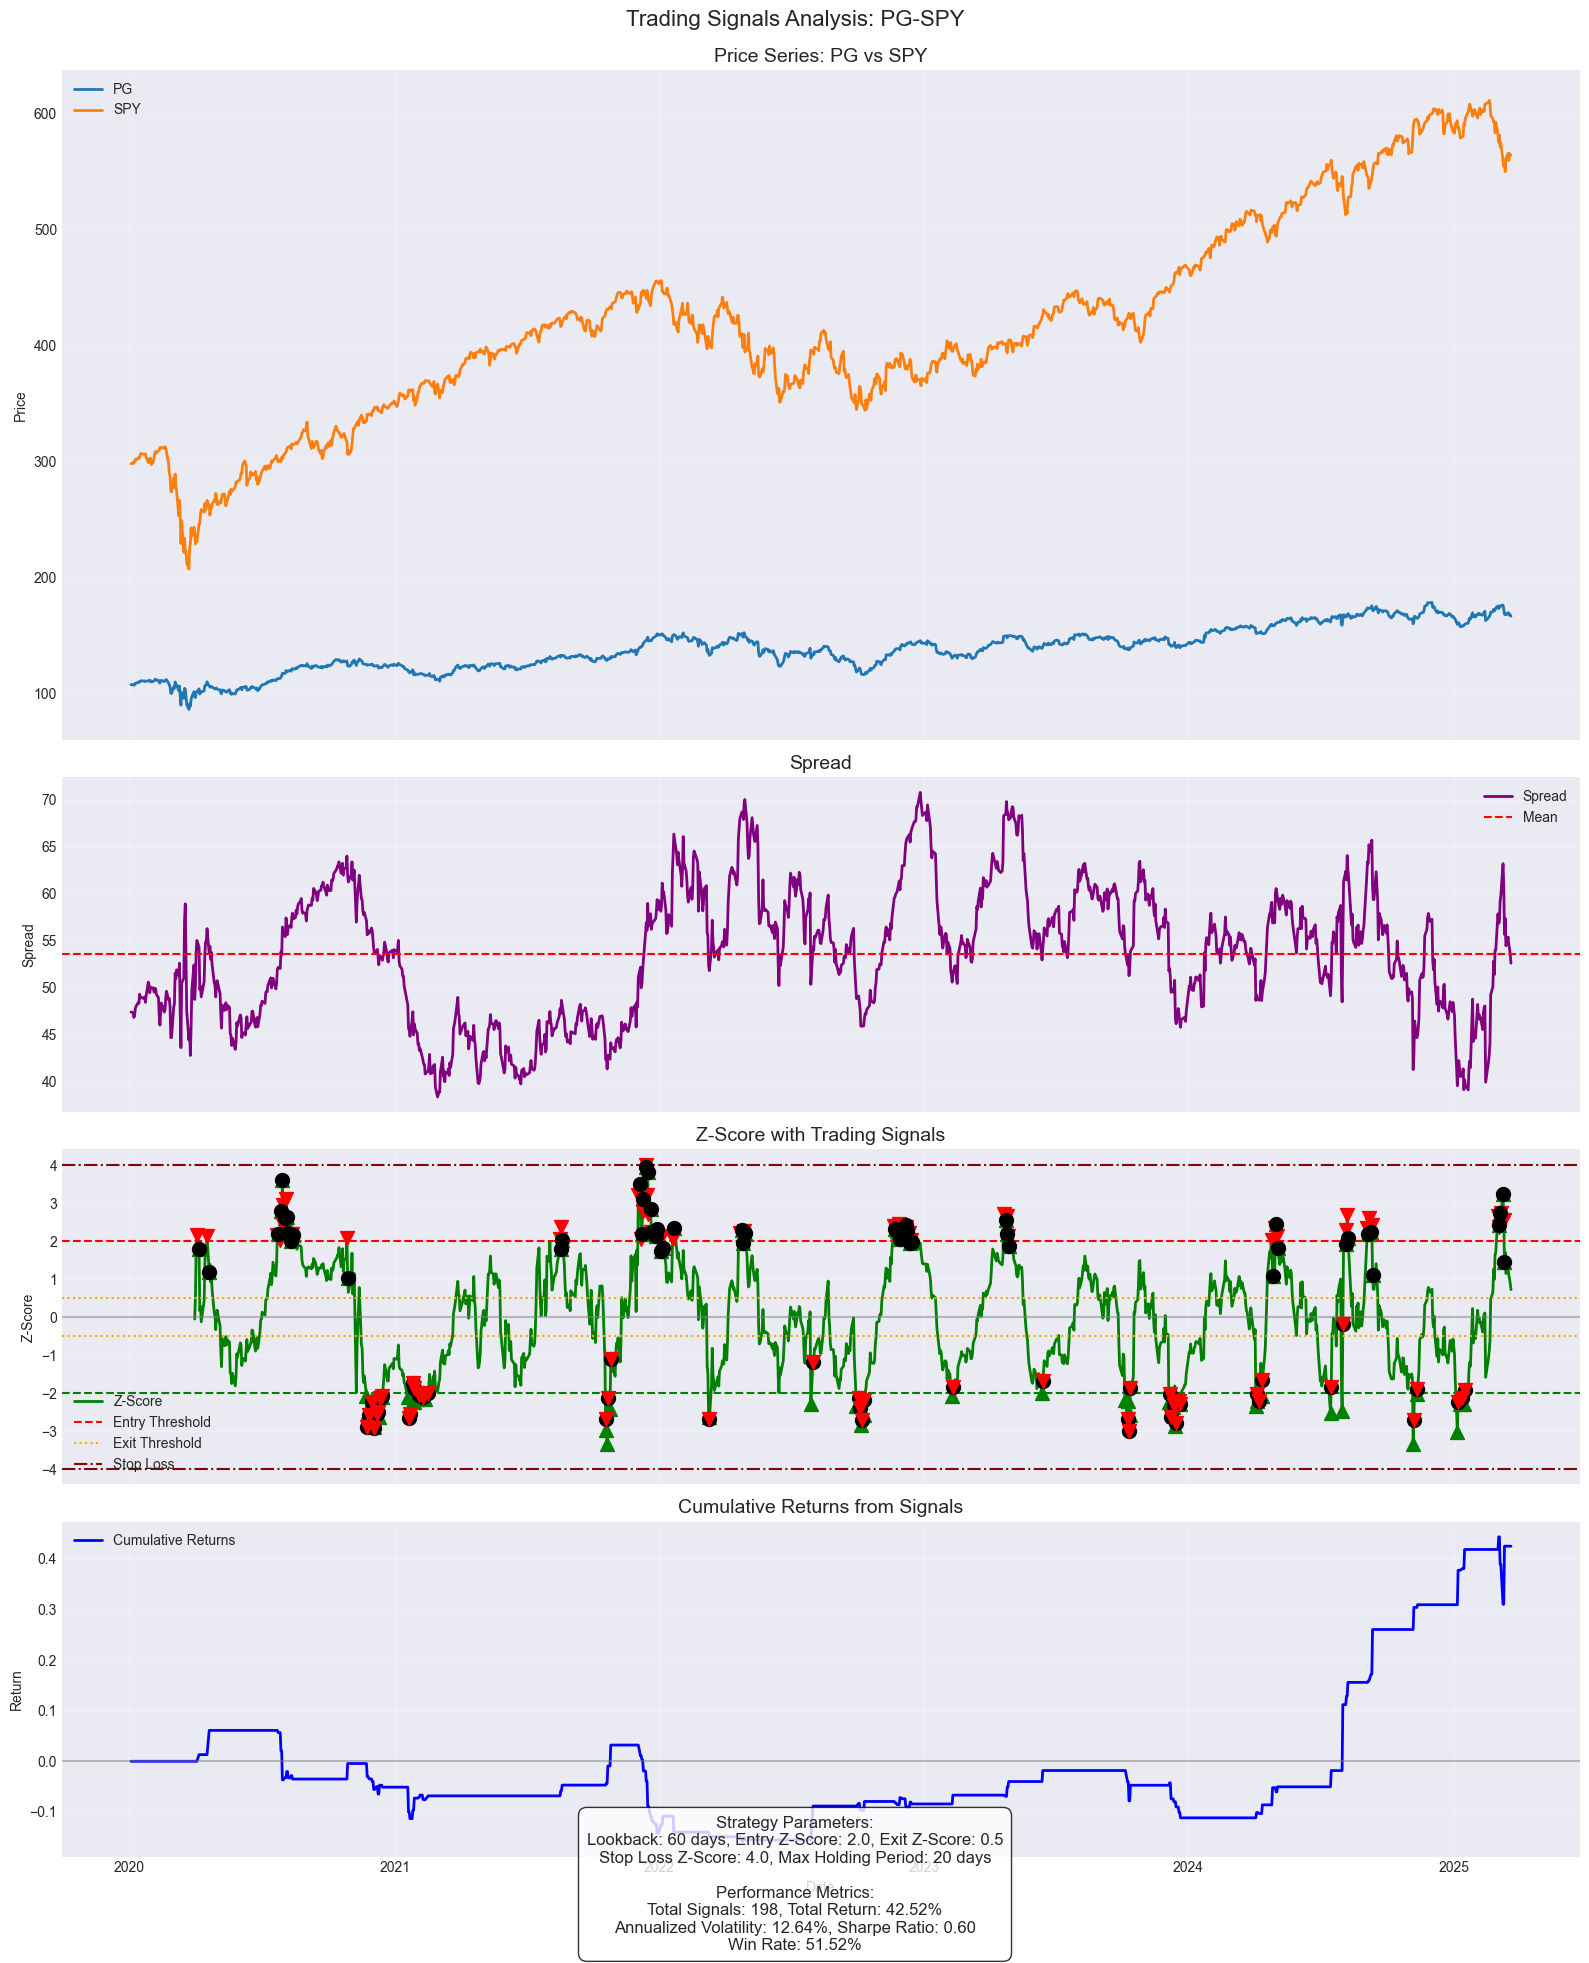

In [24]:
for pair_name in selected_pairs:
    result_df = all_pair_results[pair_name]
    
    # Extract variables
    ticker1, ticker2 = pair_name.split('-')
    dates = result_df['Date']
    price1 = result_df['Price1']
    price2 = result_df['Price2']
    spread = result_df['Spread']
    zscore = result_df['Z-Score']
    signals = result_df['Signal']
    cum_returns = result_df['CumulativeReturn']
    
    # Identify signal changes (entries and exits)
    signal_changes = np.diff(signals, prepend=0)
    
    # Long entries (signal changes from 0 to 1)
    long_entries = np.where(signal_changes == 1)[0]
    
    # Long exits (signal changes from 1 to 0 or 1 to -1)
    long_exits = np.where((signals[:-1] == 1) & (signal_changes[1:] != 0))[0] + 1
    
    # Short entries (signal changes from 0 to -1)
    short_entries = np.where(signal_changes == -1)[0]
    
    # Short exits (signal changes from -1 to 0 or -1 to 1)
    short_exits = np.where((signals[:-1] == -1) & (signal_changes[1:] != 0))[0] + 1
    
    # Create a 3-subplot figure: prices, spread, z-score and signals
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 20), sharex=True,
                                            gridspec_kw={'height_ratios': [2, 1, 1, 1]})
    
    # Plot 1: Price series
    ax1.plot(dates, price1, label=ticker1, linewidth=2)
    ax1.plot(dates, price2, label=ticker2, linewidth=2)
    ax1.set_title(f'Price Series: {ticker1} vs {ticker2}', fontsize=14)
    ax1.set_ylabel('Price')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Spread
    ax2.plot(dates, spread, label='Spread', color='purple', linewidth=2)
    ax2.axhline(y=np.nanmean(spread), color='r', linestyle='--', label='Mean')
    ax2.set_title(f'Spread', fontsize=14)
    ax2.set_ylabel('Spread')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Z-Score with entry/exit thresholds
    ax3.plot(dates, zscore, label='Z-Score', color='green', linewidth=2)
    ax3.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
    ax3.axhline(y=entry_threshold, color='r', linestyle='--', label='Entry Threshold')
    ax3.axhline(y=-entry_threshold, color='g', linestyle='--')
    ax3.axhline(y=exit_threshold, color='orange', linestyle=':', label='Exit Threshold')
    ax3.axhline(y=-exit_threshold, color='orange', linestyle=':')
    ax3.axhline(y=stop_loss, color='darkred', linestyle='-.', label='Stop Loss')
    ax3.axhline(y=-stop_loss, color='darkred', linestyle='-.')
    ax3.set_title('Z-Score with Trading Signals', fontsize=14)
    ax3.set_ylabel('Z-Score')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Add markers for entries and exits
    for idx in long_entries:
        ax3.scatter(dates.iloc[idx], zscore[idx], color='g', marker='^', s=100, zorder=5, label='Long Entry' if idx == long_entries[0] else '')
    
    for idx in long_exits:
        if idx < len(dates):
            ax3.scatter(dates.iloc[idx], zscore[idx], color='black', marker='o', s=100, zorder=5, label='Long Exit' if idx == long_exits[0] else '')
    
    for idx in short_entries:
        ax3.scatter(dates.iloc[idx], zscore[idx], color='r', marker='v', s=100, zorder=5, label='Short Entry' if idx == short_entries[0] else '')
    
    for idx in short_exits:
        if idx < len(dates):
            ax3.scatter(dates.iloc[idx], zscore[idx], color='black', marker='o', s=100, zorder=5, label='Short Exit' if idx == short_exits[0] else '')
    
    # Plot 4: Cumulative returns
    ax4.plot(dates, cum_returns, label='Cumulative Returns', color='blue', linewidth=2)
    ax4.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
    ax4.set_title('Cumulative Returns from Signals', fontsize=14)
    ax4.set_xlabel('Date')
    ax4.set_ylabel('Return')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # Add strategy parameters and performance as text
    total_signals = np.sum(np.diff(signals) != 0)
    # Fix: Use iloc to safely get the last element
    total_return = result_df['CumulativeReturn'].iloc[-1] if len(result_df) > 0 else 0
    
    # Calculate additional metrics
    non_nan_returns = result_df['Return'][~np.isnan(result_df['Return'])].values
    if len(non_nan_returns) > 0:
        volatility = np.std(non_nan_returns) * np.sqrt(252)  # Annualized
        sharpe = (np.mean(non_nan_returns) * 252) / volatility if volatility > 0 else 0
        winning_trades = np.sum(non_nan_returns > 0)
        losing_trades = np.sum(non_nan_returns < 0)
        win_rate = winning_trades / (winning_trades + losing_trades) if (winning_trades + losing_trades) > 0 else 0
    else:
        volatility, sharpe, win_rate = 0, 0, 0
    
    # Add text with parameters and performance
    text = (f"Strategy Parameters:\n"
            f"Lookback: {lookback_period} days, Entry Z-Score: {entry_threshold}, Exit Z-Score: {exit_threshold}\n"
            f"Stop Loss Z-Score: {stop_loss}, Max Holding Period: {max_holding_period} days\n\n"
            f"Performance Metrics:\n"
            f"Total Signals: {total_signals}, Total Return: {total_return:.2%}\n"
            f"Annualized Volatility: {volatility:.2%}, Sharpe Ratio: {sharpe:.2f}\n"
            f"Win Rate: {win_rate:.2%}")
    
    plt.figtext(0.5, 0.01, text, ha='center', fontsize=12, 
               bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.suptitle(f'Trading Signals Analysis: {pair_name}', fontsize=16)
    plt.subplots_adjust(top=0.95)
    plt.show()



In [25]:
# 6. Analyze signal performance
logger.info("Analyzing signal performance")



[ 2025-05-11 20:10:37,267 ] 2 trading_signals_notebook - INFO - Analyzing signal performance


In [26]:
# Create a DataFrame for performance comparison of all pairs
performance_summary = []


In [27]:
for pair_name, result_df in all_pair_results.items():
    # Calculate metrics
    signals = result_df['Signal'].values
    returns = result_df['Return'].values
    cum_returns = result_df['CumulativeReturn'].values
    
    total_signals = np.sum(np.diff(signals) != 0)
    # Fix: Use iloc to safely get the last element
    total_return = result_df['CumulativeReturn'].iloc[-1] if len(result_df) > 0 else 0
    
    # Calculate additional metrics
    non_nan_returns = returns[~np.isnan(returns)]
    if len(non_nan_returns) > 0:
        volatility = np.std(non_nan_returns) * np.sqrt(252)  # Annualized
        sharpe = (np.mean(non_nan_returns) * 252) / volatility if volatility > 0 else 0
        
        # Calculate max drawdown
        cum_returns_series = pd.Series(cum_returns)
        rolling_max = cum_returns_series.cummax()
        drawdown = (cum_returns_series - rolling_max) / (1 + rolling_max)
        max_drawdown = drawdown.min()
        
        winning_trades = np.sum(non_nan_returns > 0)
        losing_trades = np.sum(non_nan_returns < 0)
        win_rate = winning_trades / (winning_trades + losing_trades) if (winning_trades + losing_trades) > 0 else 0
        
        # Calculate average win and loss
        avg_win = np.mean(non_nan_returns[non_nan_returns > 0]) if any(non_nan_returns > 0) else 0
        avg_loss = np.mean(non_nan_returns[non_nan_returns < 0]) if any(non_nan_returns < 0) else 0
        
        # Calculate profit factor
        gross_profit = np.sum(non_nan_returns[non_nan_returns > 0]) if any(non_nan_returns > 0) else 0
        gross_loss = abs(np.sum(non_nan_returns[non_nan_returns < 0])) if any(non_nan_returns < 0) else 0
        profit_factor = gross_profit / gross_loss if gross_loss > 0 else np.inf
    else:
        volatility, sharpe, max_drawdown, win_rate, avg_win, avg_loss, profit_factor = 0, 0, 0, 0, 0, 0, 0
    
    # Add to summary
    performance_summary.append({
        'Pair': pair_name,
        'TotalSignals': total_signals,
        'TotalReturn': total_return,
        'AnnualizedVolatility': volatility,
        'SharpeRatio': sharpe,
        'MaxDrawdown': max_drawdown,
        'WinRate': win_rate,
        'AvgWin': avg_win,
        'AvgLoss': avg_loss,
        'ProfitFactor': profit_factor,
        'ReturnToDrawdown': abs(total_return / max_drawdown) if max_drawdown != 0 else np.inf
    })


In [28]:
# Convert to DataFrame and sort by Return-to-Drawdown ratio
performance_df = pd.DataFrame(performance_summary)
performance_df = performance_df.sort_values('ReturnToDrawdown', ascending=False)

# Display the performance summary
print("Performance Summary (sorted by Return-to-Drawdown ratio):")
display(performance_df)


Performance Summary (sorted by Return-to-Drawdown ratio):


,Pair,TotalSignals,TotalReturn,AnnualizedVolatility,SharpeRatio,MaxDrawdown,WinRate,AvgWin,AvgLoss,ProfitFactor,ReturnToDrawdown
7,AAPL-CAT,248,3.874713,0.765384,0.710750,-0.674485,0.532258,0.101601,-0.066820,1.730233,5.744696
0,AAPL-PG,212,0.442997,0.113679,0.676967,-0.131725,0.613208,0.018514,-0.019586,1.498562,3.363047
1,IBKR-TMUS,268,1.050875,0.752905,0.407511,-0.404162,0.492537,0.064220,-0.038858,1.604072,2.600130
2,PG-SPY,198,0.425240,0.126384,0.600524,-0.206722,0.515152,0.023415,-0.016652,1.493977,2.057066
9,CSCO-MS,198,0.282597,0.117022,0.465903,-0.139526,0.457627,0.020800,-0.013119,1.337831,2.025415
8,AAPL-KO,246,0.351283,0.193536,0.395673,-0.249165,0.512195,0.032040,-0.027002,1.245895,1.409841
10,CSCO-MSCI,202,0.292125,0.179160,0.359497,-0.221332,0.495050,0.029892,-0.022736,1.288971,1.319852
5,CALM-TMUS,218,-0.999361,0.742715,-0.998036,-0.999475,0.440367,0.066328,-0.115411,0.452236,0.999886
4,MSFT-PG,208,0.255714,0.119902,0.424670,-0.311937,0.576923,0.019870,-0.021076,1.285658,0.819763
3,CAT-MSFT,244,0.132452,11.182400,0.487945,-1.105502,0.483607,0.749368,-0.251214,2.793595,0.119811


In [29]:
# 7. Visualize comparative performance
logger.info("Visualizing comparative performance")


[ 2025-05-11 20:10:59,644 ] 2 trading_signals_notebook - INFO - Visualizing comparative performance


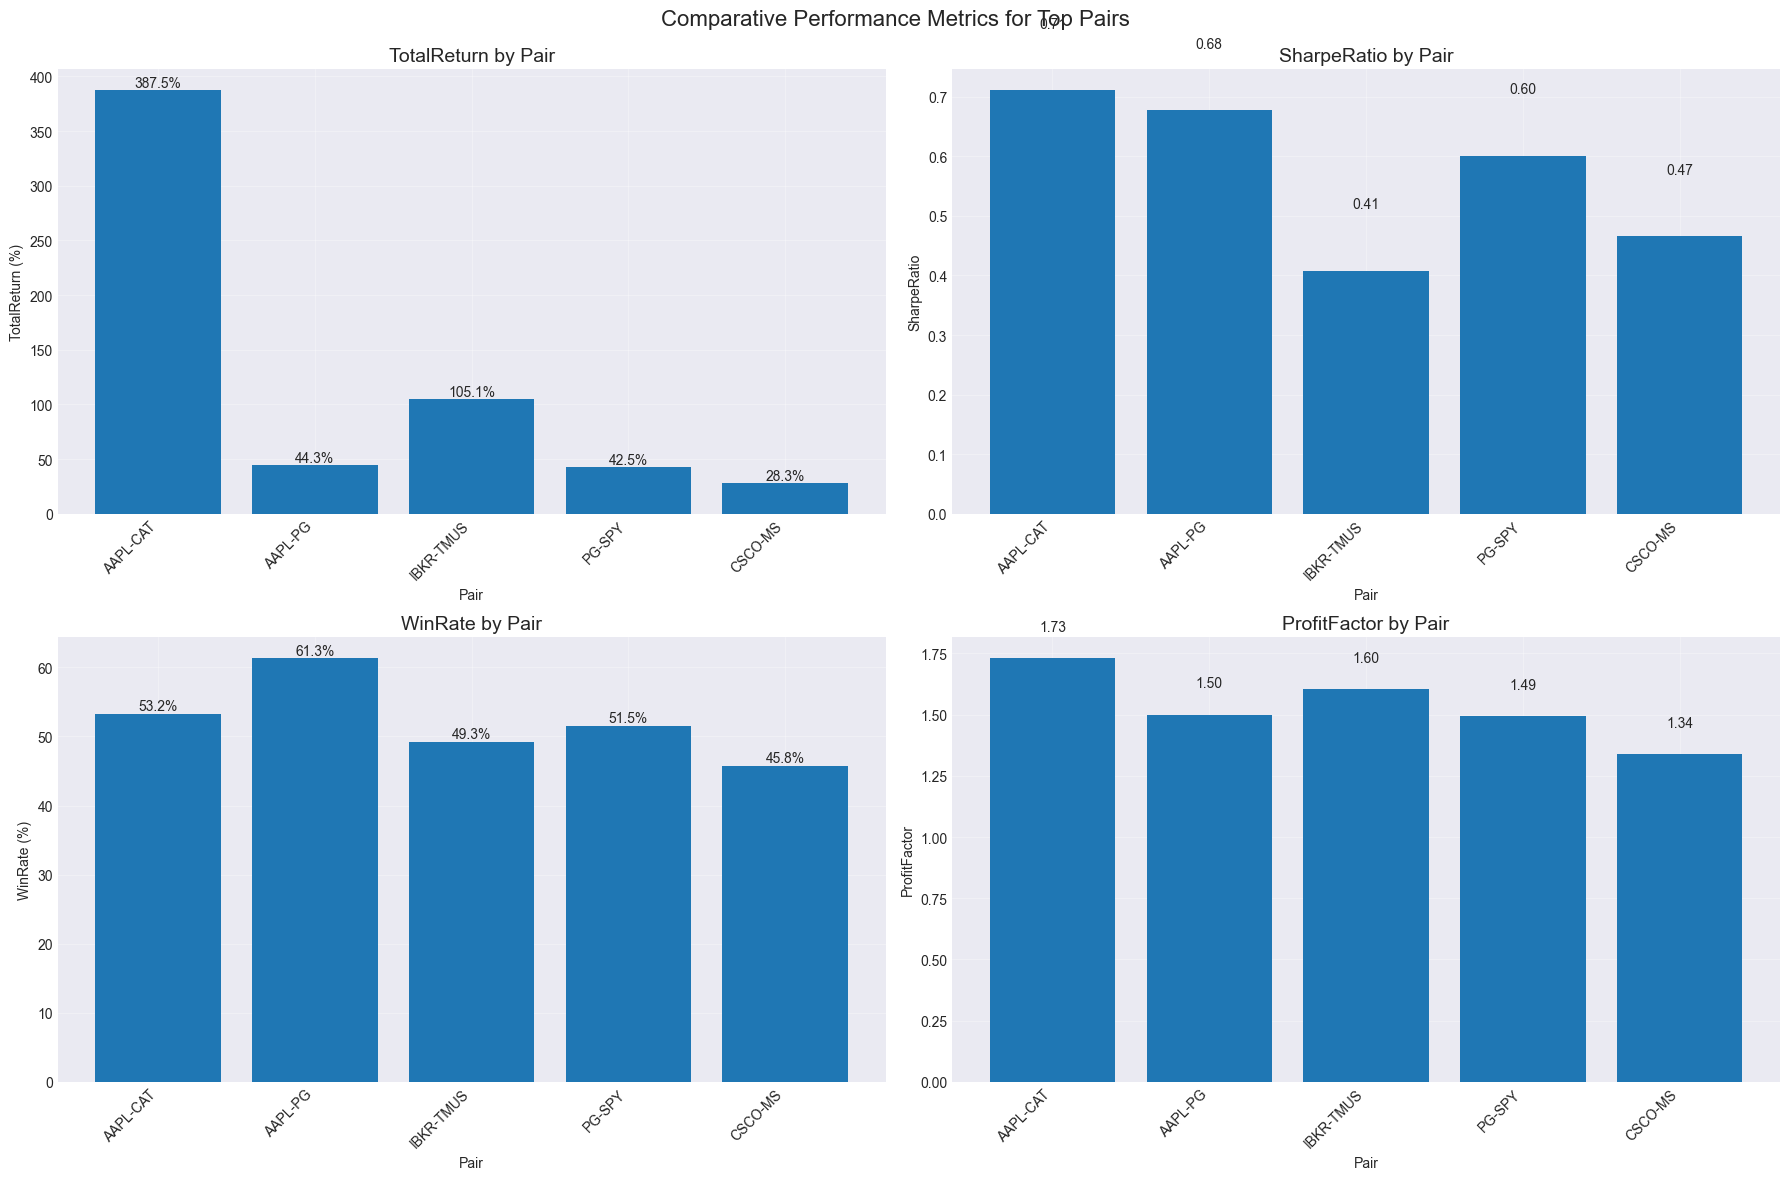

In [30]:
# Create a plot comparing key metrics across pairs
metrics_to_plot = ['TotalReturn', 'SharpeRatio', 'WinRate', 'ProfitFactor']
top_n_pairs = min(5, len(performance_df))  # Top 5 pairs or fewer if less than 5

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    
    # Format the data
    if metric in ['TotalReturn', 'WinRate', 'MaxDrawdown']:
        plot_data = performance_df.head(top_n_pairs)[metric] * 100  # Convert to percentage
        ylabel = f'{metric} (%)'
    else:
        plot_data = performance_df.head(top_n_pairs)[metric]
        ylabel = metric
    
    # Create the bar chart
    bars = ax.bar(performance_df.head(top_n_pairs)['Pair'], plot_data)
    
    # Add data labels
    for bar in bars:
        height = bar.get_height()
        if np.isfinite(height):  # Avoid issues with inf values
            if metric in ['TotalReturn', 'WinRate', 'MaxDrawdown']:
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.1, f'{height:.1f}%',
                        ha='center', va='bottom', rotation=0)
            else:
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.1, f'{height:.2f}',
                        ha='center', va='bottom', rotation=0)
    
    # Set title and labels
    ax.set_title(f'{metric} by Pair', fontsize=14)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Pair')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Comparative Performance Metrics for Top Pairs', fontsize=16)
plt.subplots_adjust(top=0.93)
plt.show()



In [31]:
# 8. Save signal generation results
logger.info("Saving signal generation results")

# Create directory if it doesn't exist
signals_dir = os.path.join('..', 'data', 'processed', 'signals')
os.makedirs(signals_dir, exist_ok=True)

# Save each pair's results
for pair_name, result_df in all_pair_results.items():
    file_path = os.path.join(signals_dir, f"{pair_name.replace('-', '_')}_signals.csv")
    result_df.to_csv(file_path, index=False)
    logger.info(f"Saved signal results for {pair_name} to {file_path}")

# Save performance summary
performance_path = os.path.join(signals_dir, "performance_summary.csv")
performance_df.to_csv(performance_path, index=False)
logger.info(f"Saved performance summary to {performance_path}")

print(f"Signal generation results saved to {signals_dir}")


[ 2025-05-11 20:11:16,283 ] 2 trading_signals_notebook - INFO - Saving signal generation results
[ 2025-05-11 20:11:16,305 ] 12 trading_signals_notebook - INFO - Saved signal results for AAPL-PG to ..\data\processed\signals\AAPL_PG_signals.csv
[ 2025-05-11 20:11:16,324 ] 12 trading_signals_notebook - INFO - Saved signal results for IBKR-TMUS to ..\data\processed\signals\IBKR_TMUS_signals.csv
[ 2025-05-11 20:11:16,339 ] 12 trading_signals_notebook - INFO - Saved signal results for PG-SPY to ..\data\processed\signals\PG_SPY_signals.csv
[ 2025-05-11 20:11:16,358 ] 12 trading_signals_notebook - INFO - Saved signal results for CAT-MSFT to ..\data\processed\signals\CAT_MSFT_signals.csv
[ 2025-05-11 20:11:16,378 ] 12 trading_signals_notebook - INFO - Saved signal results for MSFT-PG to ..\data\processed\signals\MSFT_PG_signals.csv
[ 2025-05-11 20:11:16,397 ] 12 trading_signals_notebook - INFO - Saved signal results for CALM-TMUS to ..\data\processed\signals\CALM_TMUS_signals.csv
[ 2025-05-11 

Signal generation results saved to ..\data\processed\signals
